In [236]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from netuno import SSTHelper, SubserieDTW
from sklearn.multioutput import MultiOutputRegressor

In [238]:
f_inv = lambda x: x + 180
f = lambda x: ((x+180) % 360) - 180

In [286]:
fp = '../dados/sst.mnmean.nc'
ds = SSTHelper.load_dataset(fp)
df = SSTHelper.load_dataframe(ds)

## Obtendo 5 pontos no mar
* Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [ ]:
# enso = SubserieDTW(df, 20, f_inv(-132), 1500, 48)
split_date = '1975-01-01'

chil = SubserieDTW(df, -22, f_inv(-72), split_date, forecast_horizon=5)
medi = SubserieDTW(df, 36, f_inv(18), split_date, forecast_horizon=5)
atla = SubserieDTW(df, 0, f_inv(-2), split_date, forecast_horizon=5)

indi = SubserieDTW(df, -56, f_inv(-80), split_date, forecast_horizon=5)

Initializing
Lat: -22, Lon: 108
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786
Initializing
Lat: 36, Lon: 198
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786
Initializing
Lat: 0, Lon: 178
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786
Initializing
Lat: -56, Lon: 100
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786


### DS (Dynamic time warping + Support vector regression)
Implementando a técnica de forecasting apresentada pelo artigo [Improved Particle Swarm Optimization for Sea Surface Temperature Prediction](https://www.mdpi.com/1996-1073/13/6/1369) nomeada DS. Nesse algoritmo, para prever as próximas $x$ observações pegamos a janela referente as últimas observações que possuímos e procuramos subséries anteriores de mesmo tamanho utilizando DTW. Então, utilizamos as subséries mais próximas e as respectivas próximas $x$ observações encontradas para treinar um SVR.

### Queremos predizer a série em '?'
![img1](../resources/img1.png)
### Pegamos a janela mais próxima de tamanho $n$ e comparamos com a série em azul
![img2](../resources/img2.png)
### Pegamos as subséries mais próximas (x) e as próximas observações (y)
![img3](../resources/img3.png)
### Treinamos um modelo regressor (SVR) para predizer os próximos valores utilizando x,y
![img4](../resources/img4.png)

In [296]:
from netuno import DSPipeline

In [302]:
pipeline = DSPipeline(df, -56, f_inv(-80), split_date, forecast_horizon=5)
pipeline.make_pipeline()

Initializing
Lat: -56, Lon: 100
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786


  0%|          | 0/1309 [00:00<?, ?it/s]

100%|██████████| 1309/1309 [00:02<00:00, 479.51it/s]


Obtained 1309 subseries


0.3764009720472507

In [298]:
%%capture
pipeline.optimize() 

In [ ]:
p1, p2 = pipeline.optimization_results()

Initializing
Lat: -56, Lon: 100
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786


  0%|          | 0/1309 [00:00<?, ?it/s]

100%|██████████| 1309/1309 [00:03<00:00, 431.65it/s]


Obtained 1309 subseries
RMSE:  0.36454396787344673


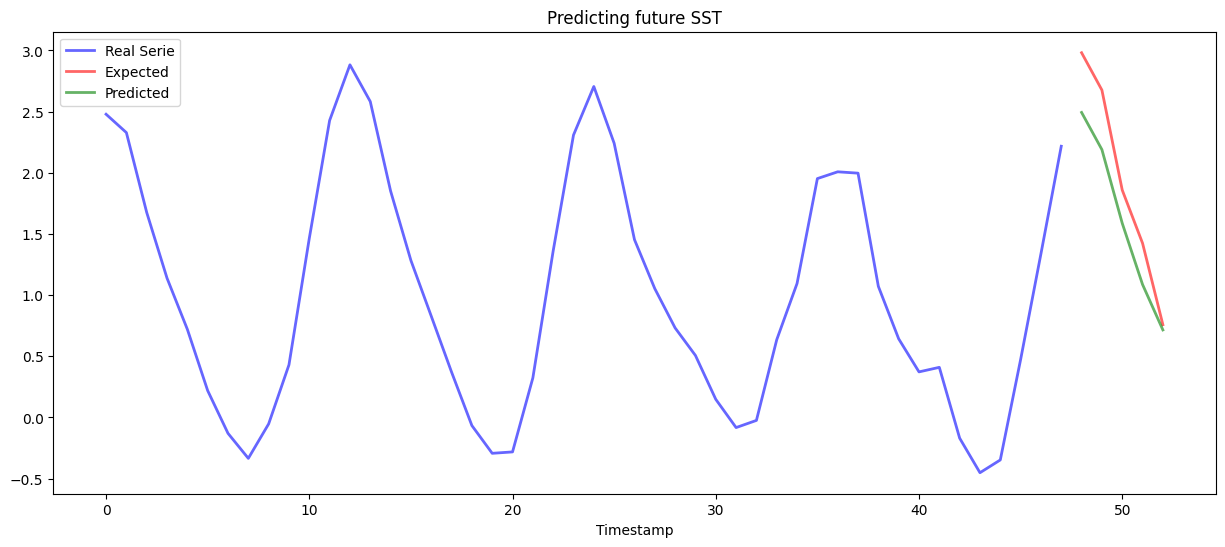

In [304]:
print("RMSE: ", pipeline.make_pipeline(1.0, 0.15))
pipeline.plot_predict()

In [305]:
pipeline1 = DSPipeline(df, -22, f_inv(-72), split_date, forecast_horizon=5)
print("RMSE: ", pipeline1.make_pipeline(1.0, 0.15))

pipeline2 = DSPipeline(df, 36, f_inv(18), split_date, forecast_horizon=5)
print("RMSE: ", pipeline2.make_pipeline(1.0, 0.15))

pipeline3 = DSPipeline(df, 0, f_inv(-2), split_date, forecast_horizon=5)
print("RMSE: ", pipeline3.make_pipeline(1.0, 0.15))


Initializing
Lat: -22, Lon: 108
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786


100%|██████████| 1309/1309 [00:03<00:00, 377.91it/s]


Obtained 1309 subseries
RMSE:  21170797534481.613
Initializing
Lat: 36, Lon: 198
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786


100%|██████████| 1309/1309 [00:02<00:00, 445.23it/s]


Obtained 1309 subseries
RMSE:  8151517072636.796
Initializing
Lat: 0, Lon: 178
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786


100%|██████████| 1309/1309 [00:03<00:00, 393.81it/s]


Obtained 1309 subseries
RMSE:  19261275539436.21
